<a href="https://colab.research.google.com/github/lindiwemutungamiri/Natural-Language_Inference/blob/main/LindiweSNI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Connecting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Connecting the GPU

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Installing the Hugging Face Library

 transformers package from Hugging Face gives us a PyTorch interface for working with BERT

In [ ]:
!pip install transformers

### Loading the SNLI dataset

Downloading and Extracting

In [ ]:
!pip install wget
!pip install gdown

The dataset is hosted in this given link https://drive.google.com/drive/folders/1LyC7MMdqv4wV7yLEhi7BlzzcmJ-w59mc?usp=sharing . Since the files are in google drive, I will use gdown.

In [ ]:
import gdown
import os

# Creating a directory to store the dataset
if not os.path.exists('./small_data'):
    os.makedirs('./small_data')

# Dictionary to map the filenames
file_ids = {
    '1-NKGkkxUHf1Tph79jpFqw--nGU3CWo1F': 'snli_dev.tsv',
    '1-D0pTXo1bFxblAmkFm-fOA0JalHyJ8W9': 'snli_test.tsv',
    '1JuaGUBWmrhKtqg2pl3sTRLONPEoRep9u': 'small_snli_train.tsv'
}

# Looping through to download each file
for file_id, filename in file_ids.items():
    destination = f'./small_data/{filename}'
    url = f'https://drive.google.com/uc?id={file_id}'

    # Download the file if it doesn't exist
    if not os.path.exists(destination):
        gdown.download(url, destination, quiet=False)


### Parsing

 using pandas to parse the "in-domain" training set and look at a few of its properties and data points.

In [ ]:
import pandas as pd

# Loading the dataset into a pandas dataframe.
df = pd.read_csv("./small_data/small_snli_train.tsv", sep='\t', names=['gold_label', 'sentence1_binary_parse', 'sentence2_binary_parse', 'sentence1_parse', 'sentence2_parse','sentence1' ,'sentence2', 'captionID', 'pairID', 'label1','label2','label3','label4','label5'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))


# Display 10 random rows from the data.
df.sample(5)


Number of training sentences: 20,001



,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
10650,neutral,( ( ( Three ( ( ( male and ) female ) pairs ) ...,( ( Tall people ) ( on stage ) ),(ROOT (S (NP (NP (CD Three) (ADJP (NN male) (C...,(ROOT (NP (NP (JJ Tall) (NNS people)) (PP (IN ...,Three male and female pairs of dancers are on ...,Tall people on stage,3247807215.jpg#0,3247807215.jpg#0r4n,neutral,NaN,NaN,NaN,NaN
2041,entailment,( ( ( ( A person ) ( in ( a ( red jacket ) ) )...,( ( The person ) ( ( is ( on ( their feet ) ) ...,(ROOT (NP (NP (NP (DT A) (NN person)) (PP (IN ...,(ROOT (S (NP (DT The) (NN person)) (VP (VBZ is...,A person in a red jacket bending over.,The person is on their feet.,4630116750.jpg#4,4630116750.jpg#4r1e,entailment,NaN,NaN,NaN,NaN
8668,neutral,( ( A ( tennis player ) ) ( ( ( returns ( a ( ...,( ( A ( tennis player ) ) ( ( is ( playing ( a...,(ROOT (S (NP (DT A) (NN tennis) (NN player)) (...,(ROOT (S (NP (DT A) (NN tennis) (NN player)) (...,A tennis player returns a serve back to his op...,A tennis player is playing a tennis match.,8112734986.jpg#3,8112734986.jpg#3r1n,neutral,NaN,NaN,NaN,NaN
1114,entailment,( ( ( Two guys ) ( in ( blue shirts ) ) ) ( ( ...,( ( The ( two men ) ) ( ( are ( working ( on (...,(ROOT (S (NP (NP (CD Two) (NNS guys)) (PP (IN ...,(ROOT (S (NP (DT The) (CD two) (NNS men)) (VP ...,Two guys in blue shirts are standing on top of...,The two men are working on a job.,5914327.jpg#0,5914327.jpg#0r1e,entailment,NaN,NaN,NaN,NaN
13902,contradiction,( ( ( Two men ) ( performing ( in ( a band ) )...,( dog ( sleeps ( in grass ) ) ),(ROOT (NP (NP (CD Two) (NNS men)) (VP (VBG per...,(ROOT (S (NP (NN dog)) (VP (VBZ sleeps) (PP (I...,Two men performing in a band.,dog sleeps in grass,1417068537.jpg#4,1417068537.jpg#4r1c,contradiction,NaN,NaN,NaN,NaN


 Using three columns from these files: (1) gold_label --Desired Output (ground_truth), (2) sentence1 and (3) sentence2 are inputs. Sampling and checking data with gold_label contradiction.

In [ ]:
df.loc[df.gold_label== 'contradiction'].sample(5)[['sentence1', 'sentence2', 'gold_label']]

,sentence1,sentence2,gold_label
17992,Travelers gather to await the arrival of their...,Travellers left without taking their baggage,contradiction
13017,Three people are sitting on a bench.,A few people are laying down.,contradiction
18449,A oriental child of approximately 3 years of a...,A teen is blowing a horn.,contradiction
17004,A man in glasses and wearing a white shirt is ...,The old man sits at the park.,contradiction
17429,Two boys are sitting to a table filled with fo...,"Two young boys, candy bars and other snacks ja...",contradiction


Extracting sentence1, sentence2, and gold_lable as numpy arrays

In [ ]:
df['gold_label'].value_counts()

contradiction    7500
neutral          7000
entailment       5500
gold_label          1
Name: gold_label, dtype: int64

In [ ]:
# Get the lists of sentences and their labels.
sentence1 = df.sentence1.values
sentence2 = df.sentence2.values
gold_label = df.gold_label.values
print(gold_label)

['gold_label' 'entailment' 'entailment' ... 'contradiction'
 'contradiction' 'contradiction']


### Plotting the Bar Chart with Label Distribution

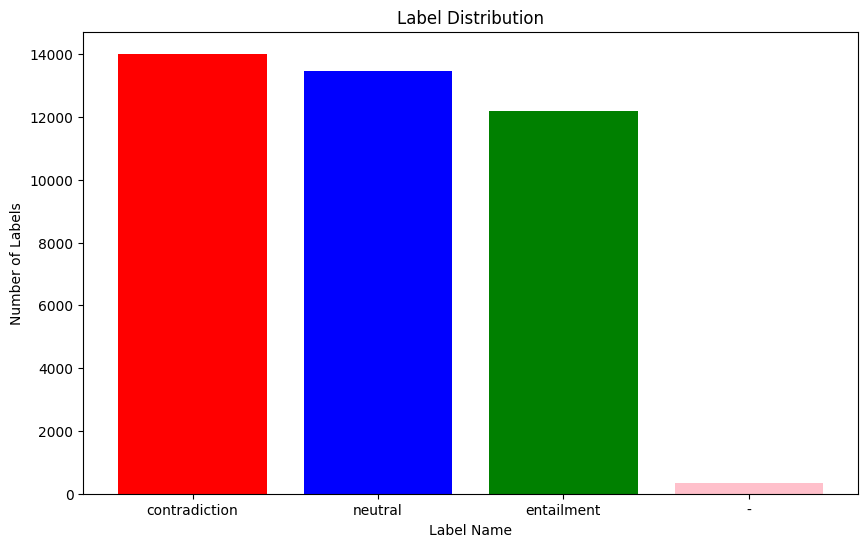

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Reading the data from three .tsv files
df1 = pd.read_csv('small_data/snli_dev.tsv', sep='\t', usecols=['gold_label', 'sentence1', 'sentence2'])
df2 = pd.read_csv('small_data/snli_test.tsv', sep='\t', usecols=['gold_label', 'sentence1', 'sentence2'])
df3 = pd.read_csv('small_data/small_snli_train.tsv', sep='\t', usecols=['gold_label', 'sentence1', 'sentence2'])

# Concatenating the three DataFrames into one
df = pd.concat([df1, df2, df3], ignore_index=True)

# Count the occurrences of each unique label
label_counts = df['gold_label'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(label_counts.index, label_counts.values, color=['red', 'blue', 'green',"pink"])
plt.xlabel('Label Name')
plt.ylabel('Number of Labels')
plt.title('Label Distribution')
plt.show()


## Roberta Tokenization and Input Formating

In [ ]:
from transformers import RobertaTokenizer

# Load theRoberta Tokenizer
print('Loading the Roberta tokenizer...')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Loading the Roberta tokenizer...


Applying the tokenizer to one input to see the results

In [ ]:
# Print the original sentence.
print(' Original: ', sentence1[2])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentence1[2]))


# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence1[2])))

 Original:  Children smiling and waving at camera
Tokenized:  ['Children', 'Ġsmiling', 'Ġand', 'Ġwaving', 'Ġat', 'Ġcamera']
Token IDs:  [31008, 12382, 8, 20615, 23, 2280]


### Tokenizing the Dataset

Performing one Tokenization pass of the dataset to measure the maximum sentence length.

In [ ]:
max_len = 0

# For every sentence...
for sent in sentence1:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)


Max sentence length:  64


max sentence length for sentence1 is 64 and for sentence 2 is 43. Just in case there are any longer sentences, I'll set the sentence max to 85.

Performing the Tokenization using the tokenizer.encode_plus function.

In [ ]:
import numpy as np
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []


# For every sentence pair...
for i, (sent1, sent2) in enumerate(zip(sentence1, sentence2)):
    # `encode_plus` will:
    #   (1) Tokenize the sentence pair.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end of each of the sentences
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent1,sent2,                # sentences to encode
                        add_special_tokens=True,    # Add '[CLS]' and '[SEP]'
                        max_length=100,             # Pad & truncate all sentences since average char length is 64 100 to make sure we don't lose the text .
                        padding='max_length',       # Pad all the sequences to the same length
                        return_attention_mask=True, # Construct attn. masks.
                        return_tensors='pt'         # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Skip the first row in input_ids and attention_masks to align with gold_label
input_ids = input_ids[1:, :]
attention_masks = attention_masks[1:, :]


# Convert labels to tensor if they aren't already

if isinstance(gold_label, np.ndarray):
    gold_label = gold_label.tolist()

# Skip the header, which is 'gold_label'
gold_label = gold_label[1:]

# Convert string labels to integer labels
label_mapping = {'neutral': 0, 'entailment': 1, 'contradiction': 2}
gold_label = [label_mapping[label] for label in gold_label]

# Convert the list to a PyTorch tensor
gold_label = torch.tensor(gold_label)

# Print first pair of sentences, now as a list of IDs.
print('Original 1: ', sentence1[1])
print('Original 2: ', sentence2[1])
print('Token IDs:', input_ids[1])



Original 1:  A person on a horse jumps over a broken down airplane.
Original 2:  A person is outdoors, on a horse.
Token IDs: tensor([    0, 31008, 12382,     8, 20615,    23,  2280,     2,     2,   970,
           32,   408,  1455,     2,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1])


### Training and Validation Split

Divide up our training set to use 90% for training and 10% for validation.


In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, gold_label)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

18,000 training samples
2,000 validation samples


In [ ]:
print(input_ids.shape)
print(attention_masks.shape)
print(gold_label.shape)


torch.Size([20000, 100])
torch.Size([20000, 100])
torch.Size([20000])


Creating an iterator for the dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### Training the Model

RoBERTa base model

In [ ]:
from transformers import RobertaModel, AdamW



model = RobertaModel.from_pretrained('roberta-base')
text = "Natural Language Inference(NLP)"
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
num_labels = 3  # Number of output labels (e.g., for entailment, contradiction, and neutral)

# Tell pytorch to run this model on the GPU.
model.to(device) #most important line because without the line we are unable to train the model

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

### Optimizer and Learning Rate Scheduler

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### Training Loop

Develop a helper function for calculation accuracy

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as hh:mm:ss



In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


Starting the Training!

In [ ]:
import random
import numpy as np
import time
import datetime
import torch
from torch import nn
from transformers import RobertaModel, AdamW, get_linear_schedule_with_warmup

# Helper function for formatting elapsed time.
def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Helper function to calculate accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Define the custom model with a RobertaClassificationHead
class RobertaClassificationHead(nn.Module):
    def __init__(self):
        super(RobertaClassificationHead, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.classifier = nn.Linear(self.roberta.config.hidden_size, 3)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]
        cls_output = sequence_output[:, 0, :]
        logits = self.classifier(cls_output)
        return logits

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RobertaClassificationHead().to(device)

# Initialize the optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)

# Seed setting for reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Initialize variables for storing training stats
training_stats = []
total_t0 = time.time()

# Training loop
for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        b_input_ids, b_attention_mask, b_labels = tuple(t.to(device) for t in batch)

        model.zero_grad()
        logits = model(b_input_ids, attention_mask=b_attention_mask)

        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits, b_labels)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    # Validation loop
    print("Running Validation...")
    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:
        b_input_ids, b_attention_mask, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input_ids, attention_mask=b_attention_mask)

            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, b_labels)

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)

    print("Validation Accuracy: {0:.2f}".format(avg_val_accuracy))
    print("Validation Loss: {0:.2f}".format(avg_val_loss))
    print("Validation took: {:}".format(validation_time))

    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Valid. Accur.': avg_val_accuracy,
        'Training Time': training_time,
        'Validation Time': validation_time
    })

print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


======== Epoch 1 / 4 ========
Average training loss: 0.63
Training epoch took: 0:04:36
Running Validation...
Validation Accuracy: 0.83
Validation Loss: 0.46
Validation took: 0:00:10
======== Epoch 2 / 4 ========
Average training loss: 0.38
Training epoch took: 0:04:36
Running Validation...
Validation Accuracy: 0.84
Validation Loss: 0.45
Validation took: 0:00:10
======== Epoch 3 / 4 ========
Average training loss: 0.27
Training epoch took: 0:04:36
Running Validation...
Validation Accuracy: 0.85
Validation Loss: 0.45
Validation took: 0:00:10
======== Epoch 4 / 4 ========
Average training loss: 0.21
Training epoch took: 0:04:35
Running Validation...
Validation Accuracy: 0.85
Validation Loss: 0.53
Validation took: 0:00:10
Training complete!
Total training took 0:19:02 (h:mm:ss)


Training Process Summary

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('display.precision', 2) #changed the precision to display.precision

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.63,0.46,0.83,0:04:36,0:00:10
2,0.38,0.45,0.84,0:04:36,0:00:10
3,0.27,0.45,0.85,0:04:36,0:00:10
4,0.21,0.53,0.85,0:04:35,0:00:10


While the the training loss is going down with each epoch, the validation loss is decreases and then increases after the third epoch! This suggests that the model is being trained too long, and it's over-fitting on the training data.

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on.

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

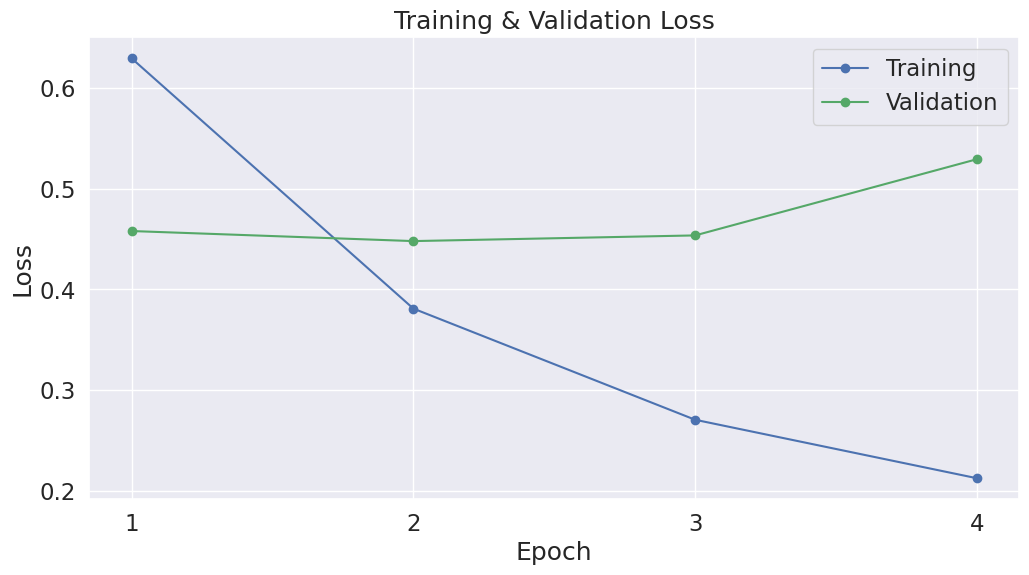

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Performance on Test

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using Matthew's correlation coefficient because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

## Data Preparation


We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./small_data/small_snli_train.tsv", sep='\t', names=['gold_label', 'sentence1_binary_parse', 'sentence2_binary_parse', 'sentence1_parse', 'sentence2_parse','sentence1' ,'sentence2', 'captionID', 'pairID', 'label1','label2','label3','label4','label5'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

FileNotFoundError: ignored